# Part 2 - Training a CellVit nuclei_type_map decoder along with the virtues encoder

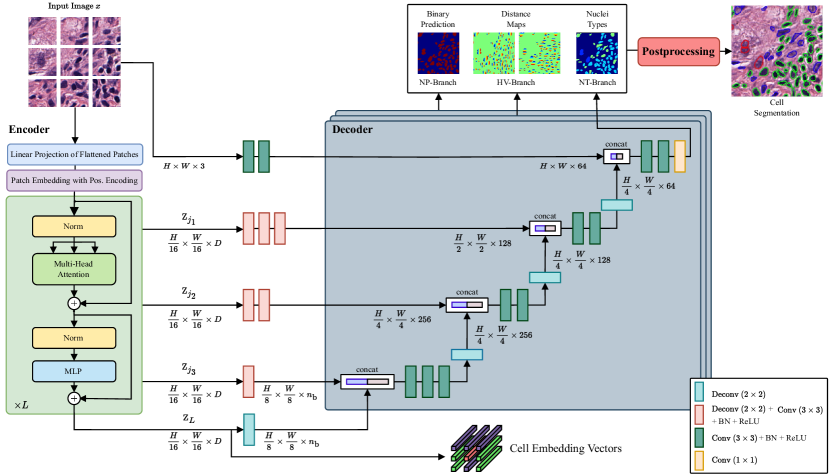

We adapt the CellVit decoder by removing one upsampling layer from each `red` block and removing the cyan upsampling layer from the bottom. This is done because VirTues uses 8px patch size and CellVit uses 16px which causes the default decoder to upsample 16x. To not lose network complexity each upsampling (ConvTranspose2D layer) is replaced by a 1x1 Convolution layer. 

For loss, we have used a weighted sum of `cross-entropy` on pixel-level reconstruction, `dice loss` and `focal-tversky loss` for class imbalance. Similar to CellVit paper.

We also updated the provided file `/src/modules/virtues/flex_dual_virtues/flex_dual_virtues_new_init.py` to enable the extraction of intermediate transformer features for skip connections in the decoder.

**Step 1 - Training decoder on precomputed embeddings from VirTues (SP only or SP + H&E embeddings)**

This method saves a lot of computational time by not recomputing embeddings for each forward pass, however it strips the possibility of using augmentations on H&E images, which is one of the most useful methods of reducing overfitting. We concluded 4 experiments in this stage:

- SP Only, no class weights, no skip connections (pss token replicated for all steps)
- SP Only, class weights, skip connections with intermediate features, stochastic patch drop
- SP + H&E, class weights, skip connections, stochastic patch drop

**Step 2 - Single run on the best previous method with additional augmentations**

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore", message=".*weights_only=False.*") # ignore warning from torch for loading models
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1" 
# 1. Get the path to the directory above the current one (i.e., the project root)
# os.getcwd() gives '.../project_root/notebook'
# '..' steps up to '.../project_root'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from config import *
print(project_root)

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle as pkl
from omegaconf import OmegaConf
from einops import rearrange
from tqdm import tqdm
import importlib

/data/code/jon/project-2-gradient_tri_scent


In [2]:
# project imports
from src.dataset.datasets.mm_base import build_mm_datasets, MultimodalDataset
from src.dataset.datasets.embeddings_dataset import EmbeddingsDataset # precomputed embeddings ds
from src.utils.plot_utils import visualize_multichannel_image
from src.modules.flex_dual_virtues.flex_dual_virtues_new_init import build_flex_dual_virtues_encoder
from src.utils.marker_utils import load_marker_embeddings
from src.utils.utils import load_checkpoint_safetensors

2025-12-14 13:30:59.369 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:<module>:23 - Using flash attention for FlexDualVirTues


In [3]:
from src.models.cellvit_decoder import CellViTDecoder
import src.utils.metrics as m
importlib.reload(m)
from src.utils.metrics import CombinedLoss, calculate_dice_score, calculate_f1_score, calculate_panoptic_quality, calculate_iou_score
from src.models.utils.train_loop import train_loop

num_classes = 10
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
device = "cuda"

In [4]:
base_cfg = OmegaConf.load("../src/dataset/configs/base_config.yaml")
base_cfg.marker_embedding_dir = "../src/dataset/esm2_t30_150M_UR50D"
marker_embeddings = load_marker_embeddings(base_cfg.marker_embedding_dir)
orion_subset_cfg = OmegaConf.load("../src/dataset/configs/orion_subset.yaml")
ds_cfg = OmegaConf.merge(base_cfg, orion_subset_cfg)

In [5]:
ds = build_mm_datasets(ds_cfg)

2025-12-14 13:31:05.115 | DEBUG    | src.dataset.datasets.mm_base:__init__:44 - Loading dataset orion from /data/virtues_orion_dataset/virtues_example/orion_subset
2025-12-14 13:31:05.123 | INFO     | src.dataset.datasets.multiplex_base:__init__:30 - Multiplex Normalization metadata: QuantileMultiplexNormalizeMetadata(normalizer_name='q_99', rnd_crop_folder_name='random_crops_256_no_log', channel_file_name='channels', mean_name='mean', std_name='std', quantile_path='quantiles/q99.csv')
2025-12-14 13:31:05.153 | INFO     | src.dataset.datasets.multiplex_base:__init__:40 - Crop folder /data/virtues_orion_dataset/virtues_example/orion_subset/cycif/random_crops_256_no_log exists
/data/code/jon/project-2-gradient_tri_scent/src/dataset/datasets/multiplex_base.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

## Visualize 1 multichannel image

In [6]:
uniprot_to_name = ds[0].unimodal_datasets["cycif"].get_marker_embedding_index_to_name_dict()

tissue_ids = ds[0].unimodal_datasets["cycif"].get_tissue_ids()
train_len = int(0.8 * len(tissue_ids))
train_tids = tissue_ids[:train_len]
test_tids = tissue_ids[train_len:]

channels = np.array(ds[0].unimodal_datasets["cycif"].get_marker_embedding_indices(tissue_ids[0]))
tissue = np.array(ds[0].unimodal_datasets["cycif"].get_tissue(tissue_ids[0]))

print(f"Tissue shape: {tissue.shape}")
print(f"SP: {list(map(lambda x: uniprot_to_name[x], channels))}")

#visualize_multichannel_image(tissue)
#plt.show()

Tissue shape: (16, 3000, 3000)
SP: ['CD31', 'CD45', 'CD68', 'CD4', 'FOXP3', 'CD8a', 'CD45RO', 'CD20', 'PD-L1', 'CD3e', 'CD163', 'E-cadherin', 'PD-1', 'Ki67', 'Pan-CK', 'SMA']


In [7]:
# class weights for later use
from src.models.utils.class_weights import compute_class_weights

train_class_weights = compute_class_weights(train_tids, ds[0], 10)
print(train_class_weights)

tensor([ 1.0000,  6.3123, 20.0000, 11.1076,  6.5096, 20.0000, 20.0000, 20.0000,
        20.0000, 20.0000])


In [8]:
# mx_tok_config = OmegaConf.load("channel_attn_tok.yaml")

with open(VIRTUES_WEIGHTS_PATH + "/config.pkl", "rb") as f:
    virtues_cfg = pkl.load(f)

encoder = build_flex_dual_virtues_encoder(virtues_cfg, marker_embeddings)
encoder.cuda()

weights = load_checkpoint_safetensors(VIRTUES_WEIGHTS_PATH + "/checkpoints/checkpoint-94575/model.safetensors")
# rename weights
weights_encoder = {}
for k, v in weights.items():
    if k.startswith("encoder."):
        weights_encoder[k[len("encoder."):]] = v

encoder.load_state_dict(weights_encoder, strict=False)

2025-12-14 13:36:28.272 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:128 - Using protein embedding: esm with shape torch.Size([213, 640])
2025-12-14 13:36:28.276 | INFO     | src.modules.flex_dual_virtues.flex_dual_virtues_new_init:__init__:147 - Using protein fusion type: add


_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.0.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.2.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.4.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.6.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.8.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.10.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.cos', 'encoder.12.encoder_layer.multi_head_attention.pos_emb.rope1d.sin', 'encod

In [9]:
from src.models.wrappers.virtues_wrapper import VirtuesWrapper
wrapper = VirtuesWrapper(encoder=encoder, device="cuda", autocast_dtype=torch.float16)

## Custom `return_intermediates` flag

We have added a custom `return_intermediates` boolean flag to the virtues encoder in file `src/modules/flex_dual_virtues/flex_dual_virtues_new_init.py`.
This flag is used to return all the intermediate representations between the transformer layers. Using the default config, there are 16 intermediate representations. This flag can be passed to method forward_list of encoder, which causes it to return a third item in the tuple which is the representations list of length 16. Each item is a list of size N where N is the list size passed to forward list. Each item in that nested list is the same shape as a PSS token.

The `VirtuesWrapper` class processes the entire dataset, and for every tissue_id, it saves a file under path. In that file there is a dict with 2 keys which can be loaded with pytorch. These keys are `intermediate_pss` and `pss`.

# HEre Ideas for Part 3

# Boundary Attention Modules/ Supervision


In [10]:
from_scratch=False
path = os.path.join("/data", "embeddings", "virtues_sp_only")
if from_scratch:
    # SP Only, include_he_data=False by default
    wrapper.process_dataset(ds[0], return_intermediates=True, intermediate_layers=[4,8,12])
    wrapper.save_embeddings(path)
else:
    wrapper.load_embeddings(path)

100%|██████████| 35/35 [01:54<00:00,  3.26s/it]


In [12]:
print("OK")

OK


In [13]:
for key, emb in wrapper.embeddings.items():
    print(key, emb["pss"].shape, emb["intermediate_pss"][0].shape, len(emb["intermediate_pss"]))
    break

orion_aijcgfvk_0 torch.Size([140625, 512]) torch.Size([140625, 512]) 3


In [14]:
all_items = [(tid, emb["pss"], emb["intermediate_pss"]) for tid, emb in wrapper.embeddings.items()]
n = len(all_items)
train_items = all_items[: int(0.8 * n)]
test_items  = all_items[int(0.8 * n):]

# 25x25 batches from 375x375 => each is 15x15 patches => 120x120 px (120=15xpatch_size)
train_ds = EmbeddingsDataset(train_items, ds=ds[0], batches_from_item=25)
test_ds  = EmbeddingsDataset(test_items, ds=ds[0], batches_from_item=25)

def collate_batch(batch):
    _, he_img, mask, pss, intermediate_pss = zip(*batch)
    inter = [torch.stack([it[i] for it in intermediate_pss]) for i in range(len(intermediate_pss[0]))]
    return torch.stack(pss), torch.stack(mask), torch.stack(he_img), inter  # pss: (B, h, w, D), mask: (B, H, W)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, collate_fn=collate_batch, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0, collate_fn=collate_batch, pin_memory=True)

Preloading CyCIF images: 100%|██████████| 28/28 [02:20<00:00,  5.01s/it]
Processing items: 28it [00:22,  1.27it/s]
Preloading CyCIF images: 100%|██████████| 7/7 [00:33<00:00,  4.72s/it]
Processing items: 7it [00:05,  1.34it/s]


In [15]:
from src.models.cellvit_decoder import CellViTDecoder
from src.models.utils.train_loop import train_loop

In [16]:
decoder = CellViTDecoder(
    embed_dim=512,  
    num_nuclei_classes=10,
    drop_rate=0.3,
    original_channels=19, # he + sp image
    patch_dropout_rate=0.0,
    boundary_attention=True
)
decoder.to(device)

optimizer = optim.AdamW(decoder.parameters(), lr=5e-4, weight_decay=1e-2)
criterion = CombinedLoss(num_classes=num_classes) # CE + Dice + Focal-Tversky
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-6)

In [18]:
decoder, train_losses, val_losses, val_dices = train_loop( # printing clears every 10 epochs to not freeze jupyter
    train_loader,
    test_loader,
    decoder,
    criterion,
    optimizer,
    scheduler,
    num_epochs=100,
    early_stopping_patience=30,
    num_classes=10,
    device="cuda",
    save_path=os.path.join(checkpoint_dir, "best_cellvit_boundary_attention.pth"),
    include_skip_connections=True,
    boundary_attention=True
)

Epoch 1/100 | LR: 5.0e-04 | Train Loss: 0.8722 | Val Loss: 0.7545 | Val Dice: 0.4344
  -->  New Best Dice: 0.4344 (Saved to ./checkpoints/best_cellvit_boundary_attention.pth)
Epoch 2/100 | LR: 4.9e-04 | Train Loss: 0.6836 | Val Loss: 0.6504 | Val Dice: 0.4922
  -->  New Best Dice: 0.4922 (Saved to ./checkpoints/best_cellvit_boundary_attention.pth)
Epoch 3/100 | LR: 4.7e-04 | Train Loss: 0.6435 | Val Loss: 0.6290 | Val Dice: 0.5382
  -->  New Best Dice: 0.5382 (Saved to ./checkpoints/best_cellvit_boundary_attention.pth)
Epoch 4/100 | LR: 4.5e-04 | Train Loss: 0.6214 | Val Loss: 0.6080 | Val Dice: 0.5703
  -->  New Best Dice: 0.5703 (Saved to ./checkpoints/best_cellvit_boundary_attention.pth)
Epoch 5/100 | LR: 4.3e-04 | Train Loss: 0.6071 | Val Loss: 0.5944 | Val Dice: 0.5797
  -->  New Best Dice: 0.5797 (Saved to ./checkpoints/best_cellvit_boundary_attention.pth)
Epoch 6/100 | LR: 4.0e-04 | Train Loss: 0.5978 | Val Loss: 0.5992 | Val Dice: 0.5812
  -->  New Best Dice: 0.5812 (Saved to .

In [19]:
# Save to cached
np.savez(
    os.path.join(checkpoint_dir, "training_metrics.npz"),
    train_losses=np.array(train_losses),
    val_losses=np.array(val_losses),
    val_dices=np.array(val_dices),
)

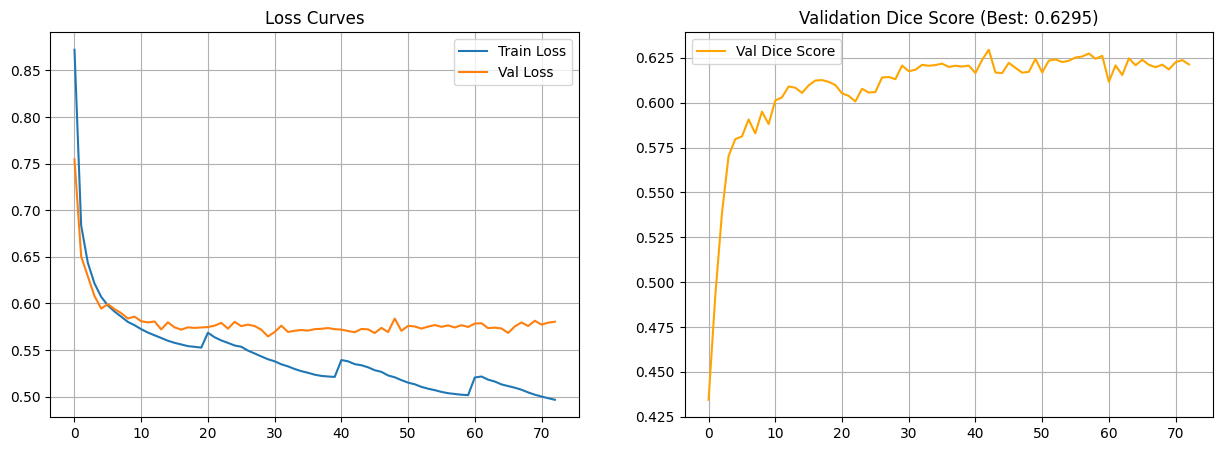

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice Score', color='orange')
plt.title(f'Validation Dice Score (Best: {np.max(val_dices):.4f})')
plt.legend()
plt.grid(True)
plt.show()

## Visualize example outputs from the decoder

Here we created an additional dataset from test_items, with the only difference being batches_from_item is set to 5 instead of 25. This causes each patch to be larger and enables us to see more.

In [ ]:
decoder.eval()

vis_ds = EmbeddingsDataset(test_items, ds=ds[0], batches_from_item=5)

show_images = 4
dataset_len = len(vis_ds)
indices = [int((dataset_len / show_images) * i) for i in range(show_images)]

with torch.no_grad():
    for row, idx in enumerate(indices):
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        tid, img, mask, pss, intermediate_pss = vis_ds[idx]

        pss = pss.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device).long()
        img = img.unsqueeze(0).to(device)
        intermediate_pss = [ip.unsqueeze(0).to(device) for ip in intermediate_pss]

        input = [img] + intermediate_pss + [pss]

        outputs = decoder(input)
        pred_logits = outputs["nuclei_type_map"]
        pred_mask = torch.argmax(pred_logits, dim=1)

        dice = calculate_dice_score(pred_mask, mask, num_classes)

        # Load full HE image for visualization
        he_img = ds[0].unimodal_datasets["he"]._get_tissue_all_channels(tid)
        he_vis = (
            he_img.transpose(1, 2, 0)
            if he_img.shape[0] == 3
            else he_img[0]
        )

        axes[0].imshow(he_vis)
        axes[0].set_title("H&E")
        axes[0].axis("off")

        axes[1].imshow(
            mask[0].cpu().numpy(),
            cmap="tab20",
            vmin=0,
            vmax=num_classes - 1,
        )
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(
            pred_mask[0].cpu().numpy(),
            cmap="tab20",
            vmin=0,
            vmax=num_classes - 1,
        )
        axes[2].set_title(f"Prediction (Dice: {dice:.3f})")
        axes[2].axis("off")

        del pss, mask, img, intermediate_pss, input, outputs, pred_logits, pred_mask
        torch.cuda.empty_cache()

        plt.tight_layout()
        plt.show()


Preloading CyCIF images:  29%|██▊       | 2/7 [00:24<01:01, 12.24s/it]